In [3]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

In [4]:
def dualOptimizer_hardmargins(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))
    h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def dualOptimizer_softmargins(H,m,y,C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((m)), np.eye(m))))
    h = cvxopt_matrix(np.vstack((np.zeros((m,1)), np.ones((m,1)) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

In [5]:
''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C=10000  #Taking C to be 10000 in the constraint. For a higher value of C we get a more stricter margin for the dataset as seen in the observation below 
alphas_hard = dualOptimizer_hardmargins(H,m,y)
alphas_soft = dualOptimizer_softmargins(H,m,y,C)
#Selecting the set of indices S corresponding to non zero parameters
S = (alphas_hard > 1e-4).flatten()
S1= (alphas_soft > 1e-4).flatten()
w = ((y[S] * alphas_hard[S]).T @ X[S]).reshape(-1,1)
w1= ((y[S] * alphas_soft[S]).T @ X[S]).reshape(-1,1)
#Computing b
b = predb(y[S],alphas_hard[S],X[S],X[S])
b1= predb(y[S],alphas_soft[S],X[S],X[S])

#Display results
print('Alphas for hard margins: ',alphas_hard,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_hard[alphas_hard > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

(8, 8) (1, 8)
(8, 8) (1, 8)
Alphas for hard margins:  [[7.67849580e-12]
 [6.04559297e-12]
 [1.51489620e-11]
 [1.97677417e-12]
 [7.60613306e-12]
 [8.28744185e-12]
 [1.69113571e+01]
 [5.01033651e-11]
 [4.19398861e-12]
 [5.99929833e+01]
 [4.14760331e-11]
 [4.39257107e-12]
 [5.46070030e-12]
 [4.66938667e-12]
 [7.78921882e-12]
 [1.53796634e-11]
 [6.91335930e-12]
 [8.96212551e-12]
 [1.22005216e-11]
 [2.52816959e-12]
 [4.05065703e-11]
 [3.09997413e-12]
 [8.75246152e-12]
 [6.64656050e-12]
 [5.03843557e-12]
 [8.33966195e-11]
 [8.79930790e-12]
 [4.77796869e-12]
 [2.32060187e-12]
 [4.71353027e-12]
 [1.96802057e-11]
 [1.42811894e-11]
 [5.38762652e-12]
 [1.11576436e-11]
 [8.52537572e-12]
 [3.12747298e-12]
 [4.84170650e-12]
 [3.27705736e-12]
 [4.68870921e-11]
 [4.73313725e-09]
 [9.26205421e-12]
 [3.03583911e-11]
 [6.87902816e+01]
 [3.88764673e-12]
 [2.34130882e-12]
 [3.57443851e-12]
 [3.70898958e-12]
 [1.40862622e-11]
 [3.77119669e-12]
 [5.04559468e-12]
 [3.54393101e-12]
 [5.79904461e-12]
 [4.554356

In [6]:
print('Alphas for soft margins: ',alphas_soft,'\n Support Vectors: ',S1.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_soft[alphas_soft > 1e-4])
print('w = ', w1.flatten())
print('b = ', b1)

Alphas for soft margins:  [[6.64483257e-13]
 [5.00506314e-13]
 [1.32548270e-12]
 [2.19029071e-13]
 [6.65420057e-13]
 [6.60473476e-13]
 [1.69113571e+01]
 [1.47862343e-12]
 [4.27740000e-13]
 [5.99929833e+01]
 [1.66735279e-12]
 [3.46601413e-13]
 [4.46737770e-13]
 [4.59947057e-13]
 [6.86247157e-13]
 [1.22491909e-12]
 [6.19290767e-13]
 [7.47819663e-13]
 [1.03249488e-12]
 [2.78068312e-13]
 [2.77585007e-12]
 [3.28978657e-13]
 [8.22994105e-13]
 [5.30175138e-13]
 [4.16897928e-13]
 [6.58056113e-12]
 [7.16543089e-13]
 [4.15968203e-13]
 [2.44750091e-13]
 [4.09397415e-13]
 [1.66603765e-12]
 [1.38295264e-12]
 [4.46569611e-13]
 [1.09891315e-12]
 [6.89291461e-13]
 [3.24239902e-13]
 [3.93162758e-13]
 [3.45498739e-13]
 [2.35011887e-12]
 [2.08760025e-10]
 [7.99119967e-13]
 [7.66397710e-12]
 [6.87902816e+01]
 [3.24472202e-13]
 [2.47630259e-13]
 [3.67529048e-13]
 [2.96858048e-13]
 [1.49870845e-12]
 [3.47426041e-13]
 [4.05532054e-13]
 [3.69111170e-13]
 [4.60549869e-13]
 [2.07697439e-12]
 [3.79482780e-13]
 [

<a list of 3 text.Text objects>

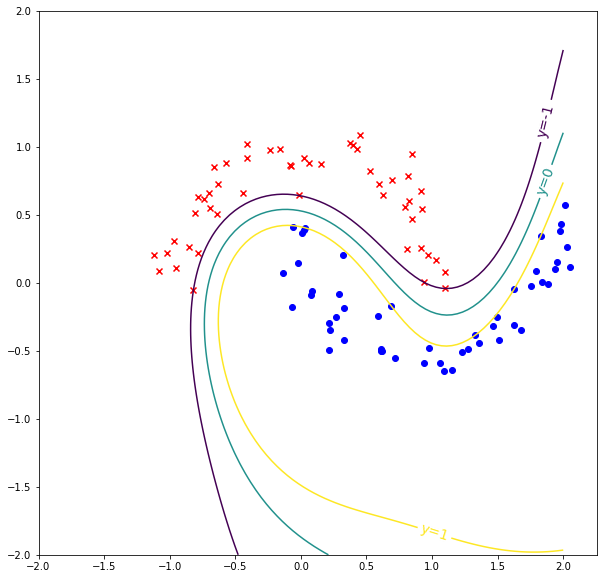

In [7]:
fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas_hard[S],X[S],p,b)
#print(pr)
'''hardmargin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas_hard[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=14)

<a list of 3 text.Text objects>

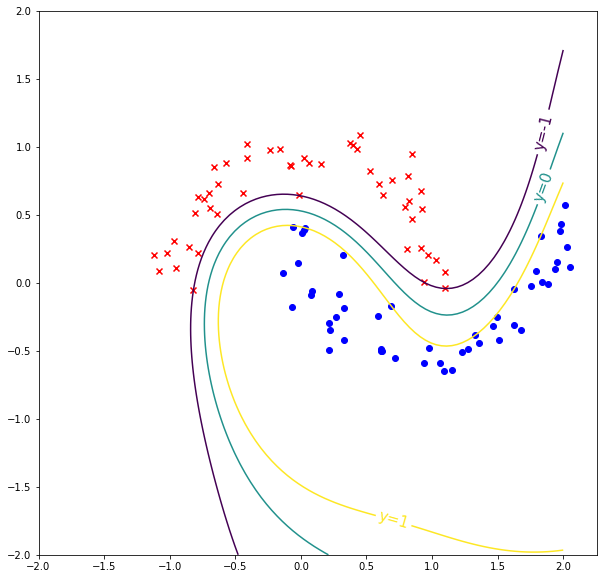

In [8]:
fig1 = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x_0, x_1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p1 = np.array([x_0, x_1]).reshape(2, -1).T
pr1 = pred(y[S],alphas_soft[S],X[S],p1,b1)
#print(pr)
'''softmargin hyperplanes for C=10000'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp1 = plt.contour(x_0, x_1, pred(y[S],alphas_soft[S],X[S],p1,b1).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp1, fmt='y=%.f', inline=True, fontsize=15)